In [2]:
import numpy as np
import matplotlib.pyplot as plt
import access_spectrum as acs
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/usr/lib/python2.7/site-packages/setuptools-18.7.1-py2.7.egg/pkg_resources/__init__.py:1266: UserWarning: /home/price-jones/.python-eggs is writable by group/others and vulnerable to attack when used with get_resource_filename. Consider a more secure location (set with .set_extraction_path or the PYTHON_EGG_CACHE environment variable).


In [3]:
# Diagonalization test
Cov = np.array([[3,1],[1,4]])
L = np.linalg.cholesky(Cov)
eig = np.linalg.eig(Cov)
np.dot(np.linalg.inv(eig[1]),np.dot(Cov,eig[1]))

array([[  2.38196601e+00,   2.21168772e-16],
       [  1.55471964e-16,   4.61803399e+00]])

In [1]:
def consth(n,model,N,D):
    hs = np.ones(n)
    hs = np.sqrt((1./len(model.weights[model.weights!=0]))*np.sum(1./model.weights[model.weights!=0]))*hs
    return hs

def hi(n,model,N,D,simplecov=True):
    sigs = np.ma.masked_array(1./model.weights)
    sigs.mask=model.weights==0
    sigs = np.ma.sqrt(sigs)
    if simplecov:
        C = np.ma.diag(np.ma.mean(sigs**2,axis = 0))
    elif not simplecov:
        C = np.ma.cov(sigs.T)
    plt.pcolor(C,cmap='plasma')
    E = model.eigvec.T
    H = np.ma.dot(E.T,np.ma.dot(C,E))
    hs = np.ma.diag(H)
    return np.sqrt(hs)
                            

def calculate_Ncells(model,N=None,D=None,denom=None,denomfunc=consth):
    """
    model:      EMPCA model object that contains eigenvalues
    N:          Number of measurements in the data set (i.e. number of stars)
    D:          Number of dimensions in each measurement (i.e. pixels)
    denom:      If None, compute denominator(s) with denomfunc. Else uses denominators as set.
    denomfunc:  A function used to compute the denominator(s). Assumes the same uncertainty across the entire data set by default
    
    """
    numeig = len(model.eigval)
    if not N or not D:
        D = model.data.shape[1]
        N = model.data.shape[0]
    if denom:
        try:
            denom = denom*np.ones(numeig) # Tile out the denominator values into an array
        except ValueError as e:
            print 'Input denominator array has invalid shape, should be {0}'.format(len(model.eigval))
            print e
            return None
    elif not denom:
        denom = denomfunc(numeig,model,N,D)
    print denom
    def calcNcells(n,denom,D,N):
        if D < N:
            return np.prod(np.sqrt(D*model.eigval[:n+1]))/np.prod(denom[:n+1])
        elif N < D:
            return np.prod(np.sqrt(N*model.eigval[:n+1]))/((D/N)*np.prod(denom[:n+1]))
    Ncells = np.zeros(numeig)
    for n in range(len(model.eigval)):
        Ncells[n] = calcNcells(n,denom,D,N)
    return Ncells,denom

### Constant h test ###

masked_array(data = [0.7745966692414834 0.7745966692414834 0.7745966692414834
 0.7745966692414834 0.7745966692414834],
             mask = [False False False False False],
       fill_value = 1e+20)

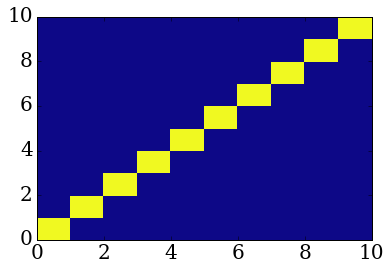

In [26]:
class testmodel(object):
    def __init__(self,N=1e3,D=2):
        self.N = N
        self.D = D
    def same_sig(self,var=0.5):
        self.weights = (1./var)
        self.weights = self.weights*np.ones((self.N,self.D))
    def eigvec(self,n=10):
        self.eigvec = np.zeros((n,D))
        for i in range(n):
            self.eigvec[i,i] = 1
        
N = 1e3
D = 10
n = 5
t = testmodel(N=N,D=D)
t.same_sig(var=0.6)
t.eigvec(n=n)
consth(1,t,N,D)**2
hi(n,t,N,D,simplecov=True)

### 4700 < TEFF < 4800 ###

In [ ]:
fname = 'red_clump_12_TEFF_up4800.0_lo4700.0/eig60_minSNR50_corrNone_madTrue.pkl'
model = acs.pklread(fname)
print model.weights.shape

maxeigplot = 60
if maxeigplot =='all':
    maxeigplot = len(model.eigval)

lamnoise = model.data.shape[0]*model.eigval[np.where(model.R2Array<model.R2noise)[0][-1]]
Ncells,denom = calculate_Ncells(model,denom = np.sqrt(lamnoise))
eigvecnum = np.arange(1,maxeigplot+1)#,len(model.eigval)+1)
plt.figure(figsize=(8,6))
plt.axvline(4,color='r',lw=2)
plt.axvline(5,color='r',lw=2)
uplim = np.log10(np.max(Ncells[:maxeigplot]))
uplim = 10**np.ceil(uplim)
plt.fill_between(np.arange(4,6),1,uplim,alpha=0.25,color='r')
plt.text(5+0.03*maxeigplot,10,'Ting+ (2015)\n prediction',fontsize=15)
if np.max(Ncells[:maxeigplot]) > 1e3:
    plt.axhline(1e3,lw=2,color='b')
plt.semilogy(eigvecnum,Ncells[:maxeigplot],'ko-',lw=2)
plt.xlim(1,maxeigplot)
plt.ylim(1,uplim)
plt.ylabel('Number of cells')
plt.xlabel('Number of eigenvectors')


Ncells,denom = calculate_Ncells(model)
plt.figure(figsize=(8,6))
plt.axvline(4,color='r',lw=2)
plt.axvline(5,color='r',lw=2)
uplim = np.log10(np.max(Ncells[:maxeigplot]))
uplim = 10**np.ceil(uplim)
plt.fill_between(np.arange(4,6),1,uplim,alpha=0.25,color='r')
plt.text(5+0.03*maxeigplot,1e4,'Ting+ (2015)\n prediction',fontsize=15)
if np.max(Ncells[:maxeigplot]) > 1e3:
    plt.axhline(1e3,lw=2,color='b')
plt.semilogy(eigvecnum,Ncells[:maxeigplot],'ko-',lw=2)
plt.xlim(1,maxeigplot)
plt.ylim(1,uplim)
plt.ylabel('Number of cells')
plt.xlabel('Number of eigenvectors')

Ncells,denom = calculate_Ncells(model,denomfunc=hi)
plt.figure(figsize=(8,6))
plt.axvline(4,color='r',lw=2)
plt.axvline(5,color='r',lw=2)
uplim = np.log10(np.max(Ncells[:maxeigplot]))
uplim = 10**np.ceil(uplim)
plt.fill_between(np.arange(4,6),1,uplim,alpha=0.25,color='r')
plt.text(5+0.03*maxeigplot,1e4,'Ting+ (2015)\n prediction',fontsize=15)
if np.max(Ncells[:maxeigplot]) > 1e3:
    plt.axhline(1e3,lw=2,color='b')
plt.semilogy(eigvecnum,Ncells[:maxeigplot],'ko-',lw=2)
plt.xlim(1,maxeigplot)
plt.ylim(1,uplim)
plt.ylabel('Number of cells')
plt.xlabel('Number of eigenvectors')

(4107, 7214)
[ 0.06160232  0.06160232  0.06160232  0.06160232  0.06160232  0.06160232
  0.06160232  0.06160232  0.06160232  0.06160232  0.06160232  0.06160232
  0.06160232  0.06160232  0.06160232  0.06160232  0.06160232  0.06160232
  0.06160232  0.06160232  0.06160232  0.06160232  0.06160232  0.06160232
  0.06160232  0.06160232  0.06160232  0.06160232  0.06160232  0.06160232
  0.06160232  0.06160232  0.06160232  0.06160232  0.06160232  0.06160232
  0.06160232  0.06160232  0.06160232  0.06160232  0.06160232  0.06160232
  0.06160232  0.06160232  0.06160232  0.06160232  0.06160232  0.06160232
  0.06160232  0.06160232  0.06160232  0.06160232  0.06160232  0.06160232
  0.06160232  0.06160232  0.06160232  0.06160232  0.06160232  0.06160232]
[ 0.00648412  0.00648412  0.00648412  0.00648412  0.00648412  0.00648412
  0.00648412  0.00648412  0.00648412  0.00648412  0.00648412  0.00648412
  0.00648412  0.00648412  0.00648412  0.00648412  0.00648412  0.00648412
  0.00648412  0.00648412  0.00648412 

In [42]:
model.eigvec.shape

(60, 7214)

[ 0.03611319  0.03611319  0.03611319  0.03611319  0.03611319  0.03611319
  0.03611319  0.03611319  0.03611319  0.03611319  0.03611319  0.03611319
  0.03611319  0.03611319  0.03611319  0.03611319  0.03611319  0.03611319
  0.03611319  0.03611319  0.03611319  0.03611319  0.03611319  0.03611319
  0.03611319  0.03611319  0.03611319  0.03611319  0.03611319  0.03611319
  0.03611319  0.03611319  0.03611319  0.03611319  0.03611319  0.03611319
  0.03611319  0.03611319  0.03611319  0.03611319  0.03611319  0.03611319
  0.03611319  0.03611319  0.03611319  0.03611319  0.03611319  0.03611319
  0.03611319  0.03611319  0.03611319  0.03611319  0.03611319  0.03611319
  0.03611319  0.03611319  0.03611319  0.03611319  0.03611319  0.03611319]
[ 0.00836382  0.00836382  0.00836382  0.00836382  0.00836382  0.00836382
  0.00836382  0.00836382  0.00836382  0.00836382  0.00836382  0.00836382
  0.00836382  0.00836382  0.00836382  0.00836382  0.00836382  0.00836382
  0.00836382  0.00836382  0.00836382  0.00836382  

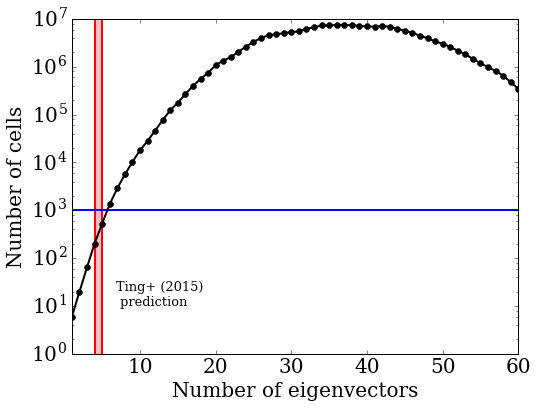

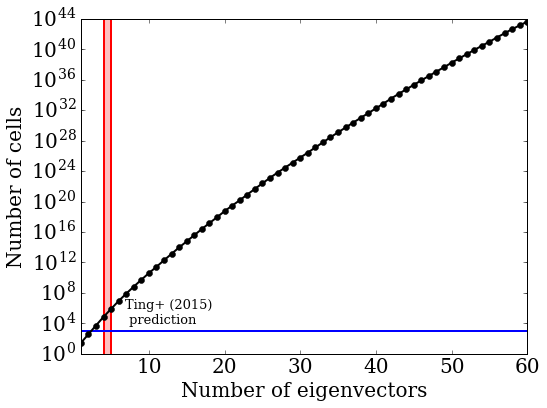

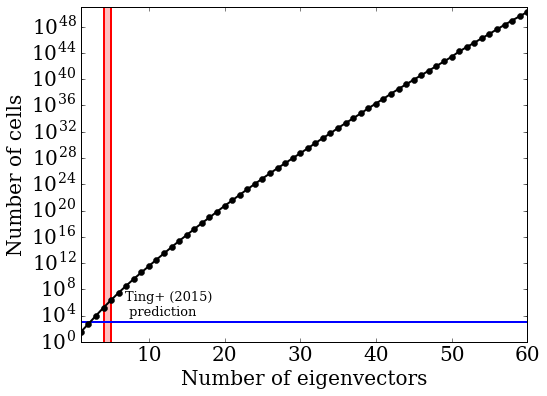

In [7]:
fname = 'red_clump_12_TEFF_up4800.0_lo4700.0/eig60_minSNR50_corr30px_madFalse.pkl'
model = acs.pklread(fname)

maxeigplot = 60
if maxeigplot =='all':
    maxeigplot = len(model.eigval)

lamnoise = model.data.shape[0]*model.eigval[np.where(model.R2Array<model.R2noise)[0][-1]]
Ncells,denom = calculate_Ncells(model,denom = np.sqrt(lamnoise))
eigvecnum = np.arange(1,maxeigplot+1)#,len(model.eigval)+1)
plt.figure(figsize=(8,6))
plt.axvline(4,color='r',lw=2)
plt.axvline(5,color='r',lw=2)
uplim = np.log10(np.max(Ncells[:maxeigplot]))
uplim = 10**np.ceil(uplim)
plt.fill_between(np.arange(4,6),1,uplim,alpha=0.25,color='r')
plt.text(5+0.03*maxeigplot,10,'Ting+ (2015)\n prediction',fontsize=13)
if np.max(Ncells[:maxeigplot]) > 1e3:
    plt.axhline(1e3,lw=2,color='b')
plt.semilogy(eigvecnum,Ncells[:maxeigplot],'ko-',lw=2)
plt.xlim(1,maxeigplot)
plt.ylim(1,uplim)
plt.ylabel('Number of cells')
plt.xlabel('Number of eigenvectors')


Ncells,denom = calculate_Ncells(model)
plt.figure(figsize=(8,6))
plt.axvline(4,color='r',lw=2)
plt.axvline(5,color='r',lw=2)
uplim = np.log10(np.max(Ncells[:maxeigplot]))
uplim = 10**np.ceil(uplim)
plt.fill_between(np.arange(4,6),1,uplim,alpha=0.25,color='r')
plt.text(5+0.03*maxeigplot,1e4,'Ting+ (2015)\n prediction',fontsize=13)
if np.max(Ncells[:maxeigplot]) > 1e3:
    plt.axhline(1e3,lw=2,color='b')
plt.semilogy(eigvecnum,Ncells[:maxeigplot],'ko-',lw=2)
plt.xlim(1,maxeigplot)
plt.ylim(1,uplim)
plt.ylabel('Number of cells')
plt.xlabel('Number of eigenvectors')

Ncells,denom = calculate_Ncells(model,denomfunc=hi)
plt.figure(figsize=(8,6))
plt.axvline(4,color='r',lw=2)
plt.axvline(5,color='r',lw=2)
uplim = np.log10(np.max(Ncells[:maxeigplot]))
uplim = 10**np.ceil(uplim)
plt.fill_between(np.arange(4,6),1,uplim,alpha=0.25,color='r')
plt.text(5+0.03*maxeigplot,1e4,'Ting+ (2015)\n prediction',fontsize=13)
if np.max(Ncells[:maxeigplot]) > 1e3:
    plt.axhline(1e3,lw=2,color='b')
plt.semilogy(eigvecnum,Ncells[:maxeigplot],'ko-',lw=2)
plt.xlim(1,maxeigplot)
plt.ylim(1,uplim)
plt.ylabel('Number of cells')
plt.xlabel('Number of eigenvectors')

### 4800 < TEFF < 4900 ###

[ 0.0661662  0.0661662  0.0661662  0.0661662  0.0661662  0.0661662
  0.0661662  0.0661662  0.0661662  0.0661662  0.0661662  0.0661662
  0.0661662  0.0661662  0.0661662  0.0661662  0.0661662  0.0661662
  0.0661662  0.0661662  0.0661662  0.0661662  0.0661662  0.0661662
  0.0661662  0.0661662  0.0661662  0.0661662  0.0661662  0.0661662
  0.0661662  0.0661662  0.0661662  0.0661662  0.0661662  0.0661662
  0.0661662  0.0661662  0.0661662  0.0661662  0.0661662  0.0661662
  0.0661662  0.0661662  0.0661662  0.0661662  0.0661662  0.0661662
  0.0661662  0.0661662  0.0661662  0.0661662  0.0661662  0.0661662
  0.0661662  0.0661662  0.0661662  0.0661662  0.0661662  0.0661662]
[ 0.00669604  0.00669604  0.00669604  0.00669604  0.00669604  0.00669604
  0.00669604  0.00669604  0.00669604  0.00669604  0.00669604  0.00669604
  0.00669604  0.00669604  0.00669604  0.00669604  0.00669604  0.00669604
  0.00669604  0.00669604  0.00669604  0.00669604  0.00669604  0.00669604
  0.00669604  0.00669604  0.00669604 

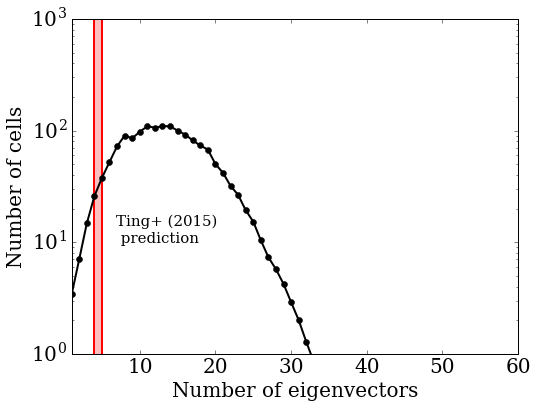

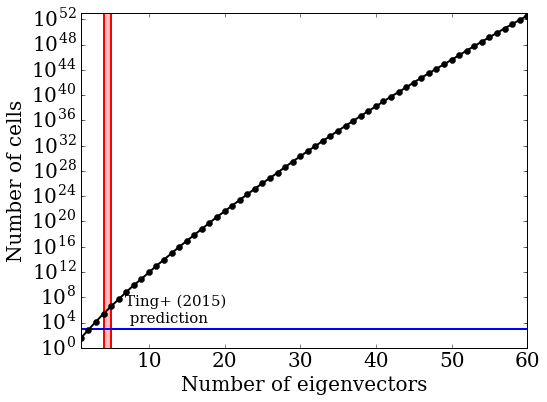

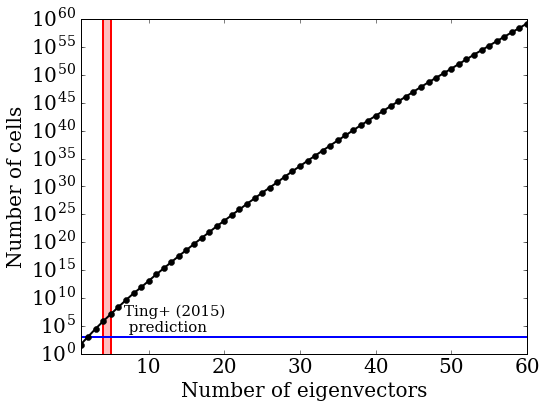

In [6]:
fname = 'red_clump_12_TEFF_up4900.0_lo4800.0/eig60_minSNR50_corrNone_madTrue.pkl'
model = acs.pklread(fname)

maxeigplot = 60
if maxeigplot =='all':
    maxeigplot = len(model.eigval)

lamnoise = model.data.shape[0]*model.eigval[np.where(model.R2Array<model.R2noise)[0][-1]]
Ncells,denom = calculate_Ncells(model,denom = np.sqrt(lamnoise))
eigvecnum = np.arange(1,maxeigplot+1)#,len(model.eigval)+1)
plt.figure(figsize=(8,6))
plt.axvline(4,color='r',lw=2)
plt.axvline(5,color='r',lw=2)
uplim = np.log10(np.max(Ncells[:maxeigplot]))
uplim = 10**np.ceil(uplim)
plt.fill_between(np.arange(4,6),1,uplim,alpha=0.25,color='r')
plt.text(5+0.03*maxeigplot,10,'Ting+ (2015)\n prediction',fontsize=15)
if np.max(Ncells[:maxeigplot]) > 1e3:
    plt.axhline(1e3,lw=2,color='b')
plt.semilogy(eigvecnum,Ncells[:maxeigplot],'ko-',lw=2)
plt.xlim(1,maxeigplot)
plt.ylim(1,uplim)
plt.ylabel('Number of cells')
plt.xlabel('Number of eigenvectors')


Ncells,denom = calculate_Ncells(model)
plt.figure(figsize=(8,6))
plt.axvline(4,color='r',lw=2)
plt.axvline(5,color='r',lw=2)
uplim = np.log10(np.max(Ncells[:maxeigplot]))
uplim = 10**np.ceil(uplim)
plt.fill_between(np.arange(4,6),1,uplim,alpha=0.25,color='r')
plt.text(5+0.03*maxeigplot,1e4,'Ting+ (2015)\n prediction',fontsize=15)
if np.max(Ncells[:maxeigplot]) > 1e3:
    plt.axhline(1e3,lw=2,color='b')
plt.semilogy(eigvecnum,Ncells[:maxeigplot],'ko-',lw=2)
plt.xlim(1,maxeigplot)
plt.ylim(1,uplim)
plt.ylabel('Number of cells')
plt.xlabel('Number of eigenvectors')

Ncells,denom = calculate_Ncells(model,denomfunc=hi)
plt.figure(figsize=(8,6))
plt.axvline(4,color='r',lw=2)
plt.axvline(5,color='r',lw=2)
uplim = np.log10(np.max(Ncells[:maxeigplot]))
uplim = 10**np.ceil(uplim)
plt.fill_between(np.arange(4,6),1,uplim,alpha=0.25,color='r')
plt.text(5+0.03*maxeigplot,1e4,'Ting+ (2015)\n prediction',fontsize=15)
if np.max(Ncells[:maxeigplot]) > 1e3:
    plt.axhline(1e3,lw=2,color='b')
plt.semilogy(eigvecnum,Ncells[:maxeigplot],'ko-',lw=2)
plt.xlim(1,maxeigplot)
plt.ylim(1,uplim)
plt.ylabel('Number of cells')
plt.xlabel('Number of eigenvectors')

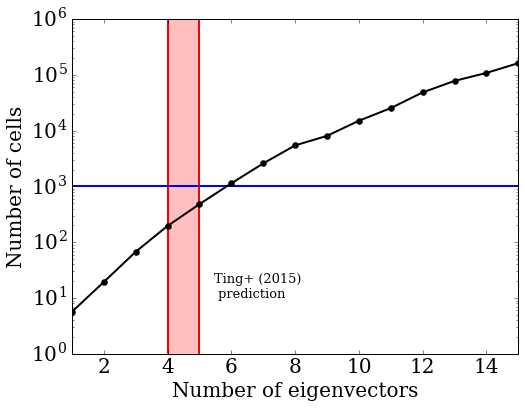

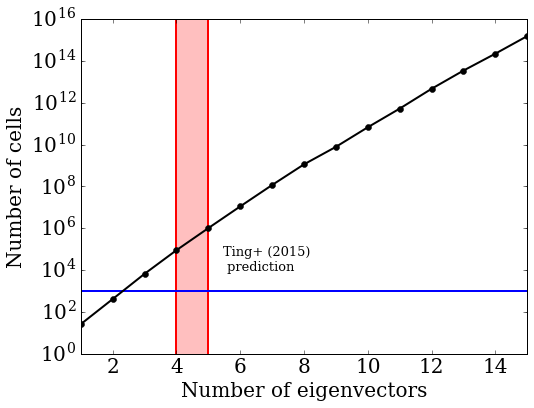

In [137]:
fname = 'red_clump_12_TEFF_up4900.0_lo4800.0/eig60_minSNR50_corr30px_madFalse.pkl'
model = acs.pklread(fname)

maxeigplot = 15
if maxeigplot =='all':
    maxeigplot = len(model.eigval)

lamnoise = model.data.shape[0]*model.eigval[np.where(model.R2Array<model.R2noise)[0][-1]]
Ncells,denom = calculate_Ncells(model,denom = np.sqrt(lamnoise))
eigvecnum = np.arange(1,maxeigplot+1)#,len(model.eigval)+1)
plt.figure(figsize=(8,6))
plt.axvline(4,color='r',lw=2)
plt.axvline(5,color='r',lw=2)
uplim = np.log10(np.max(Ncells[:maxeigplot]))
uplim = 10**np.ceil(uplim)
plt.fill_between(np.arange(4,6),1,uplim,alpha=0.25,color='r')
plt.text(5+0.03*maxeigplot,10,'Ting+ (2015)\n prediction',fontsize=13)
if np.max(Ncells[:maxeigplot]) > 1e3:
    plt.axhline(1e3,lw=2,color='b')
plt.semilogy(eigvecnum,Ncells[:maxeigplot],'ko-',lw=2)
plt.xlim(1,maxeigplot)
plt.ylim(1,uplim)
plt.ylabel('Number of cells')
plt.xlabel('Number of eigenvectors')


Ncells,denom = calculate_Ncells(model)
plt.figure(figsize=(8,6))
plt.axvline(4,color='r',lw=2)
plt.axvline(5,color='r',lw=2)
uplim = np.log10(np.max(Ncells[:maxeigplot]))
uplim = 10**np.ceil(uplim)
plt.fill_between(np.arange(4,6),1,uplim,alpha=0.25,color='r')
plt.text(5+0.03*maxeigplot,1e4,'Ting+ (2015)\n prediction',fontsize=13)
if np.max(Ncells[:maxeigplot]) > 1e3:
    plt.axhline(1e3,lw=2,color='b')
plt.semilogy(eigvecnum,Ncells[:maxeigplot],'ko-',lw=2)
plt.xlim(1,maxeigplot)
plt.ylim(1,uplim)
plt.ylabel('Number of cells')
plt.xlabel('Number of eigenvectors')

### C-C-C-Combo

0.00379484530008
0.00130416262117
0.00437796585032
0.00159506723158


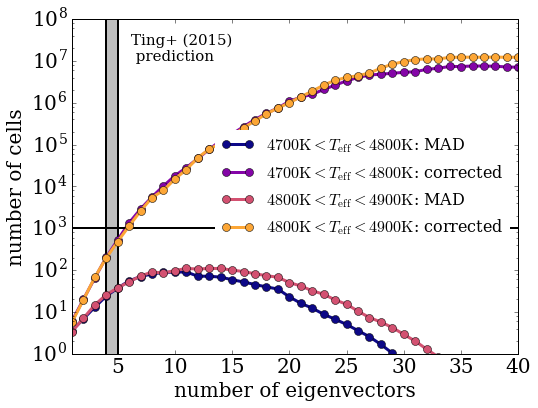

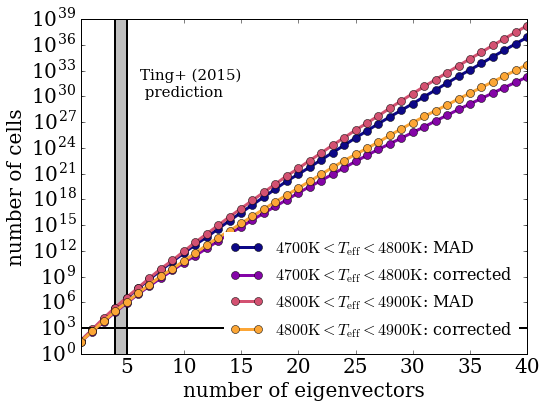

In [28]:
fnames = ['red_clump_12_TEFF_up4800.0_lo4700.0/eig60_minSNR50_corrNone_madTrue.pkl',
          'red_clump_12_TEFF_up4800.0_lo4700.0/eig60_minSNR50_corr30px_madFalse.pkl',
          'red_clump_12_TEFF_up4900.0_lo4800.0/eig60_minSNR50_corrNone_madTrue.pkl',
          'red_clump_12_TEFF_up4900.0_lo4800.0/eig60_minSNR50_corr30px_madFalse.pkl']

labels = [r'$4700\mathrm{K} < T_{\mathrm{eff}} < 4800\mathrm{K}$: MAD',
          r'$4700\mathrm{K} < T_{\mathrm{eff}} < 4800\mathrm{K}$: corrected',
          r'$4800\mathrm{K} < T_{\mathrm{eff}} < 4900\mathrm{K}$: MAD',
          r'$4800\mathrm{K} < T_{\mathrm{eff}} < 4900\mathrm{K}$: corrected']
colors = colors = plt.get_cmap('plasma')(np.linspace(0,0.8,len(fnames)))

models = []
for f in fnames:
    models.append(acs.pklread(f))

maxeigplot = 40

eigvecnum = np.arange(1,maxeigplot+1)
plt.figure(figsize=(8,6))
plt.axvline(4,color='k',lw=2)
plt.axvline(5,color='k',lw=2)
plt.xlim(1,maxeigplot)
plt.ylabel('number of cells')
plt.xlabel('number of eigenvectors')

c=0
maxval = 0
for model in models:
    lamnoise = model.data.shape[0]*model.eigval[np.where(model.R2Array<model.R2noise)[0][-1]]
    print lamnoise
    Ncells,denom = calculate_Ncells(model,denom = np.sqrt(lamnoise))
    if np.max(Ncells[:maxeigplot]) > maxval:
        maxval = np.max(Ncells[:maxeigplot])
    if c==len(models)-1:
        uplim = np.log10(maxval)
        uplim = 10**np.ceil(uplim)
        plt.fill_between(np.arange(4,6),1,uplim,alpha=0.25,color='k')
        plt.text(5+0.03*maxeigplot,10**7,'Ting+ (2015)\n prediction',fontsize=15)
        if np.max(Ncells[:maxeigplot]) > 1e3:
            plt.axhline(1e3,lw=2,color='k')
        plt.ylim(1,uplim)
    plt.semilogy(eigvecnum,Ncells[:maxeigplot],'o-',lw=3,color=colors[c],markersize=8,markerfacecolor=colors[c],label=labels[c])
    c+=1
legend = plt.legend(loc='best',fontsize=16)
legend.get_frame().set_linewidth(0.0)


plt.figure(figsize=(8,6))
plt.axvline(4,color='k',lw=2)
plt.axvline(5,color='k',lw=2)
plt.xlim(1,maxeigplot)
plt.ylabel('number of cells')
plt.xlabel('number of eigenvectors')

c=0
maxval = 0
for model in models:
    Ncells,denom = calculate_Ncells(model)
    if np.max(Ncells[:maxeigplot]) > maxval:
        maxval = np.max(Ncells[:maxeigplot])
    if c==len(models)-1:
        uplim = np.log10(maxval)
        uplim = 10**np.ceil(uplim)
        plt.fill_between(np.arange(4,6),1,uplim,alpha=0.25,color='k')
        plt.text(5+0.03*maxeigplot,10**30,'Ting+ (2015)\n prediction',fontsize=15)
        if np.max(Ncells[:maxeigplot]) > 1e3:
            plt.axhline(1e3,lw=2,color='k')
        plt.ylim(1,uplim)
    plt.semilogy(eigvecnum,Ncells[:maxeigplot],'o-',lw=3,color=colors[c],markersize=8,markerfacecolor=colors[c],label=labels[c])
    c+=1
legend = plt.legend(loc='best',fontsize=16)
legend.get_frame().set_linewidth(0.0)

### By sample ###

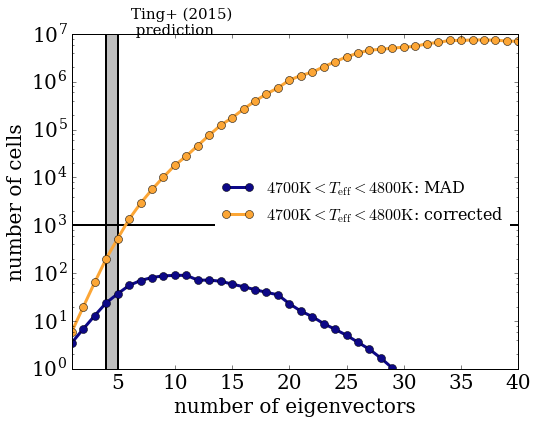

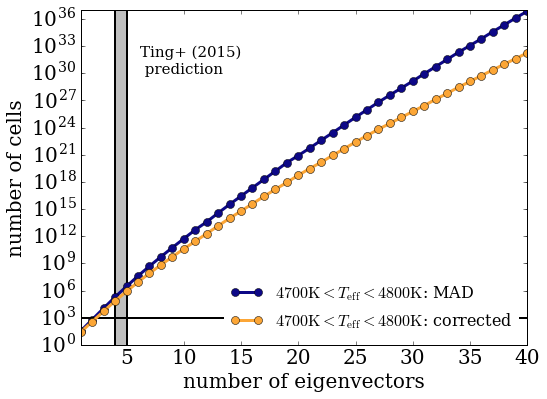

In [154]:
fnames = ['red_clump_12_TEFF_up4800.0_lo4700.0/eig60_minSNR50_corrNone_madTrue.pkl',
          'red_clump_12_TEFF_up4800.0_lo4700.0/eig60_minSNR50_corr30px_madFalse.pkl',]

labels = [r'$4700\mathrm{K} < T_{\mathrm{eff}} < 4800\mathrm{K}$: MAD',
          r'$4700\mathrm{K} < T_{\mathrm{eff}} < 4800\mathrm{K}$: corrected']

colors = colors = plt.get_cmap('plasma')(np.linspace(0,0.8,len(fnames)))

models = []
for f in fnames:
    models.append(acs.pklread(f))

maxeigplot = 40

eigvecnum = np.arange(1,maxeigplot+1)
plt.figure(figsize=(8,6))
plt.axvline(4,color='k',lw=2)
plt.axvline(5,color='k',lw=2)
plt.xlim(1,maxeigplot)
plt.ylabel('number of cells')
plt.xlabel('number of eigenvectors')

c=0
maxval = 0
for model in models:
    lamnoise = model.data.shape[0]*model.eigval[np.where(model.R2Array<model.R2noise)[0][-1]]
    Ncells,denom = calculate_Ncells(model,denom = np.sqrt(lamnoise))
    if np.max(Ncells[:maxeigplot]) > maxval:
        maxval = np.max(Ncells[:maxeigplot])
    if c==len(models)-1:
        uplim = np.log10(maxval)
        uplim = 10**np.ceil(uplim)
        plt.fill_between(np.arange(4,6),1,uplim,alpha=0.25,color='k')
        plt.text(5+0.03*maxeigplot,10**7,'Ting+ (2015)\n prediction',fontsize=15)
        if np.max(Ncells[:maxeigplot]) > 1e3:
            plt.axhline(1e3,lw=2,color='k')
        plt.ylim(1,uplim)
    plt.semilogy(eigvecnum,Ncells[:maxeigplot],'o-',lw=3,color=colors[c],markersize=8,markerfacecolor=colors[c],label=labels[c])
    c+=1
legend = plt.legend(loc='best',fontsize=16)
legend.get_frame().set_linewidth(0.0)


plt.figure(figsize=(8,6))
plt.axvline(4,color='k',lw=2)
plt.axvline(5,color='k',lw=2)
plt.xlim(1,maxeigplot)
plt.ylabel('number of cells')
plt.xlabel('number of eigenvectors')

c=0
maxval = 0
for model in models:
    Ncells,denom = calculate_Ncells(model)
    if np.max(Ncells[:maxeigplot]) > maxval:
        maxval = np.max(Ncells[:maxeigplot])
    if c==len(models)-1:
        uplim = np.log10(maxval)
        uplim = 10**np.ceil(uplim)
        plt.fill_between(np.arange(4,6),1,uplim,alpha=0.25,color='k')
        plt.text(5+0.03*maxeigplot,10**30,'Ting+ (2015)\n prediction',fontsize=15)
        if np.max(Ncells[:maxeigplot]) > 1e3:
            plt.axhline(1e3,lw=2,color='k')
        plt.ylim(1,uplim)
    plt.semilogy(eigvecnum,Ncells[:maxeigplot],'o-',lw=3,color=colors[c],markersize=8,markerfacecolor=colors[c],label=labels[c])
    c+=1
legend = plt.legend(loc='best',fontsize=16)
legend.get_frame().set_linewidth(0.0)

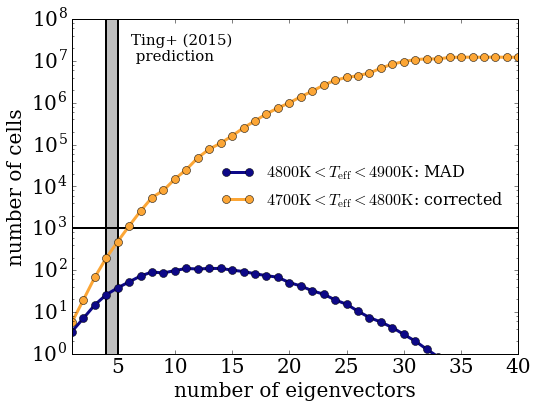

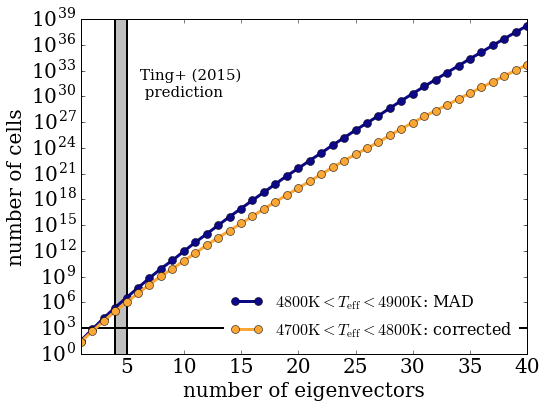

In [155]:
fnames = ['red_clump_12_TEFF_up4900.0_lo4800.0/eig60_minSNR50_corrNone_madTrue.pkl',
          'red_clump_12_TEFF_up4900.0_lo4800.0/eig60_minSNR50_corr30px_madFalse.pkl']

labels = [r'$4800\mathrm{K} < T_{\mathrm{eff}} < 4900\mathrm{K}$: MAD',
          r'$4800\mathrm{K} < T_{\mathrm{eff}} < 4900\mathrm{K}$: corrected']
colors = colors = plt.get_cmap('plasma')(np.linspace(0,0.8,len(fnames)))

models = []
for f in fnames:
    models.append(acs.pklread(f))

maxeigplot = 40

eigvecnum = np.arange(1,maxeigplot+1)
plt.figure(figsize=(8,6))
plt.axvline(4,color='k',lw=2)
plt.axvline(5,color='k',lw=2)
plt.xlim(1,maxeigplot)
plt.ylabel('number of cells')
plt.xlabel('number of eigenvectors')

c=0
maxval = 0
for model in models:
    lamnoise = model.data.shape[0]*model.eigval[np.where(model.R2Array<model.R2noise)[0][-1]]
    Ncells,denom = calculate_Ncells(model,denom = np.sqrt(lamnoise))
    if np.max(Ncells[:maxeigplot]) > maxval:
        maxval = np.max(Ncells[:maxeigplot])
    if c==len(models)-1:
        uplim = np.log10(maxval)
        uplim = 10**np.ceil(uplim)
        plt.fill_between(np.arange(4,6),1,uplim,alpha=0.25,color='k')
        plt.text(5+0.03*maxeigplot,10**7,'Ting+ (2015)\n prediction',fontsize=15)
        if np.max(Ncells[:maxeigplot]) > 1e3:
            plt.axhline(1e3,lw=2,color='k')
        plt.ylim(1,uplim)
    plt.semilogy(eigvecnum,Ncells[:maxeigplot],'o-',lw=3,color=colors[c],markersize=8,markerfacecolor=colors[c],label=labels[c])
    c+=1
legend = plt.legend(loc='best',fontsize=16)
legend.get_frame().set_linewidth(0.0)


plt.figure(figsize=(8,6))
plt.axvline(4,color='k',lw=2)
plt.axvline(5,color='k',lw=2)
plt.xlim(1,maxeigplot)
plt.ylabel('number of cells')
plt.xlabel('number of eigenvectors')

c=0
maxval = 0
for model in models:
    Ncells,denom = calculate_Ncells(model)
    if np.max(Ncells[:maxeigplot]) > maxval:
        maxval = np.max(Ncells[:maxeigplot])
    if c==len(models)-1:
        uplim = np.log10(maxval)
        uplim = 10**np.ceil(uplim)
        plt.fill_between(np.arange(4,6),1,uplim,alpha=0.25,color='k')
        plt.text(5+0.03*maxeigplot,10**30,'Ting+ (2015)\n prediction',fontsize=15)
        if np.max(Ncells[:maxeigplot]) > 1e3:
            plt.axhline(1e3,lw=2,color='k')
        plt.ylim(1,uplim)
    plt.semilogy(eigvecnum,Ncells[:maxeigplot],'o-',lw=3,color=colors[c],markersize=8,markerfacecolor=colors[c],label=labels[c])
    c+=1
legend = plt.legend(loc='best',fontsize=16)
legend.get_frame().set_linewidth(0.0)

### By type ###

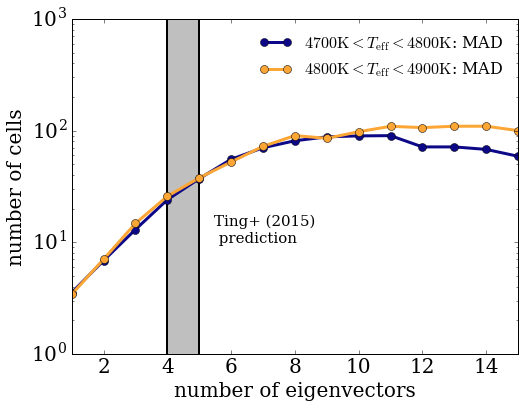

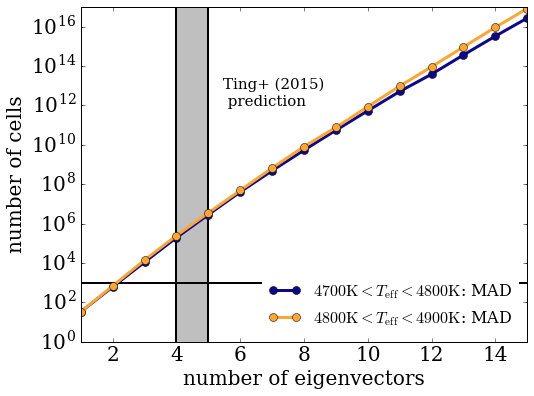

In [161]:
fnames = ['red_clump_12_TEFF_up4800.0_lo4700.0/eig60_minSNR50_corrNone_madTrue.pkl',
          'red_clump_12_TEFF_up4900.0_lo4800.0/eig60_minSNR50_corrNone_madTrue.pkl',]

labels = [r'$4700\mathrm{K} < T_{\mathrm{eff}} < 4800\mathrm{K}$: MAD',
          r'$4800\mathrm{K} < T_{\mathrm{eff}} < 4900\mathrm{K}$: MAD']

colors = colors = plt.get_cmap('plasma')(np.linspace(0,0.8,len(fnames)))

models = []
for f in fnames:
    models.append(acs.pklread(f))

maxeigplot = 15

eigvecnum = np.arange(1,maxeigplot+1)
plt.figure(figsize=(8,6))
plt.axvline(4,color='k',lw=2)
plt.axvline(5,color='k',lw=2)
plt.xlim(1,maxeigplot)
plt.ylabel('number of cells')
plt.xlabel('number of eigenvectors')

c=0
maxval = 0
for model in models:
    lamnoise = model.data.shape[0]*model.eigval[np.where(model.R2Array<model.R2noise)[0][-1]]
    Ncells,denom = calculate_Ncells(model,denom = np.sqrt(lamnoise))
    if np.max(Ncells[:maxeigplot]) > maxval:
        maxval = np.max(Ncells[:maxeigplot])
    if c==len(models)-1:
        uplim = np.log10(maxval)
        uplim = 10**np.ceil(uplim)
        plt.fill_between(np.arange(4,6),1,uplim,alpha=0.25,color='k')
        plt.text(5+0.03*maxeigplot,10,'Ting+ (2015)\n prediction',fontsize=15)
        if np.max(Ncells[:maxeigplot]) > 1e3:
            plt.axhline(1e3,lw=2,color='k')
        plt.ylim(1,uplim)
    plt.semilogy(eigvecnum,Ncells[:maxeigplot],'o-',lw=3,color=colors[c],markersize=8,markerfacecolor=colors[c],label=labels[c])
    c+=1
legend = plt.legend(loc='best',fontsize=16)
legend.get_frame().set_linewidth(0.0)
plt.savefig('Ncells_MAD_lambda_noise.pdf')


plt.figure(figsize=(8,6))
plt.axvline(4,color='k',lw=2)
plt.axvline(5,color='k',lw=2)
plt.xlim(1,maxeigplot)
plt.ylabel('number of cells')
plt.xlabel('number of eigenvectors')

c=0
maxval = 0
for model in models:
    Ncells,denom = calculate_Ncells(model)
    if np.max(Ncells[:maxeigplot]) > maxval:
        maxval = np.max(Ncells[:maxeigplot])
    if c==len(models)-1:
        uplim = np.log10(maxval)
        uplim = 10**np.ceil(uplim)
        plt.fill_between(np.arange(4,6),1,uplim,alpha=0.25,color='k')
        plt.text(5+0.03*maxeigplot,10**12,'Ting+ (2015)\n prediction',fontsize=15)
        if np.max(Ncells[:maxeigplot]) > 1e3:
            plt.axhline(1e3,lw=2,color='k')
        plt.ylim(1,uplim)
    plt.semilogy(eigvecnum,Ncells[:maxeigplot],'o-',lw=3,color=colors[c],markersize=8,markerfacecolor=colors[c],label=labels[c])
    c+=1
legend = plt.legend(loc='best',fontsize=16)
legend.get_frame().set_linewidth(0.0)
plt.savefig('Ncells_MAD_const_h.pdf')

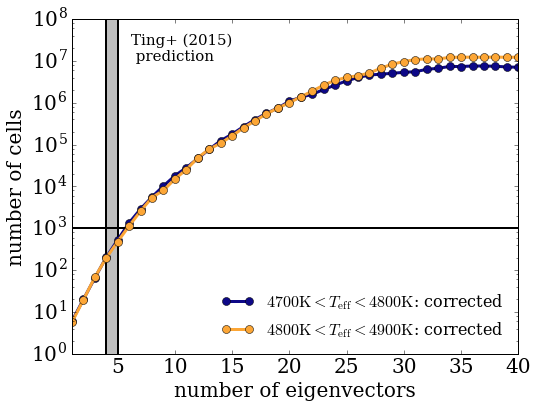

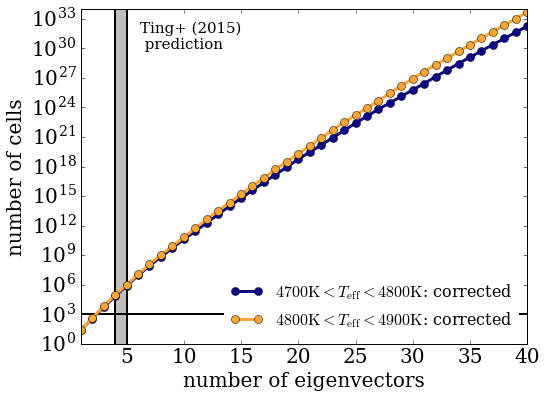

In [162]:
fnames = ['red_clump_12_TEFF_up4800.0_lo4700.0/eig60_minSNR50_corr30px_madFalse.pkl',
          'red_clump_12_TEFF_up4900.0_lo4800.0/eig60_minSNR50_corr30px_madFalse.pkl']

labels = [r'$4700\mathrm{K} < T_{\mathrm{eff}} < 4800\mathrm{K}$: corrected',
          r'$4800\mathrm{K} < T_{\mathrm{eff}} < 4900\mathrm{K}$: corrected']
colors = colors = plt.get_cmap('plasma')(np.linspace(0,0.8,len(fnames)))

models = []
for f in fnames:
    models.append(acs.pklread(f))

maxeigplot = 40

eigvecnum = np.arange(1,maxeigplot+1)
plt.figure(figsize=(8,6))
plt.axvline(4,color='k',lw=2)
plt.axvline(5,color='k',lw=2)
plt.xlim(1,maxeigplot)
plt.ylabel('number of cells')
plt.xlabel('number of eigenvectors')

c=0
maxval = 0
for model in models:
    lamnoise = model.data.shape[0]*model.eigval[np.where(model.R2Array<model.R2noise)[0][-1]]
    Ncells,denom = calculate_Ncells(model,denom = np.sqrt(lamnoise))
    if np.max(Ncells[:maxeigplot]) > maxval:
        maxval = np.max(Ncells[:maxeigplot])
    if c==len(models)-1:
        uplim = np.log10(maxval)
        uplim = 10**np.ceil(uplim)
        plt.fill_between(np.arange(4,6),1,uplim,alpha=0.25,color='k')
        plt.text(5+0.03*maxeigplot,10**7,'Ting+ (2015)\n prediction',fontsize=15)
        if np.max(Ncells[:maxeigplot]) > 1e3:
            plt.axhline(1e3,lw=2,color='k')
        plt.ylim(1,uplim)
    plt.semilogy(eigvecnum,Ncells[:maxeigplot],'o-',lw=3,color=colors[c],markersize=8,markerfacecolor=colors[c],label=labels[c])
    c+=1
legend = plt.legend(loc='best',fontsize=16)
legend.get_frame().set_linewidth(0.0)
plt.savefig('Ncells_corr_lambda_noise.pdf')

plt.figure(figsize=(8,6))
plt.axvline(4,color='k',lw=2)
plt.axvline(5,color='k',lw=2)
plt.xlim(1,maxeigplot)
plt.ylabel('number of cells')
plt.xlabel('number of eigenvectors')

c=0
maxval = 0
for model in models:
    Ncells,denom = calculate_Ncells(model)
    if np.max(Ncells[:maxeigplot]) > maxval:
        maxval = np.max(Ncells[:maxeigplot])
    if c==len(models)-1:
        uplim = np.log10(maxval)
        uplim = 10**np.ceil(uplim)
        plt.fill_between(np.arange(4,6),1,uplim,alpha=0.25,color='k')
        plt.text(5+0.03*maxeigplot,10**30,'Ting+ (2015)\n prediction',fontsize=15)
        if np.max(Ncells[:maxeigplot]) > 1e3:
            plt.axhline(1e3,lw=2,color='k')
        plt.ylim(1,uplim)
    plt.semilogy(eigvecnum,Ncells[:maxeigplot],'o-',lw=3,color=colors[c],markersize=8,markerfacecolor=colors[c],label=labels[c])
    c+=1
legend = plt.legend(loc='best',fontsize=16)
legend.get_frame().set_linewidth(0.0)
plt.savefig('Ncells_corr_const_h.pdf')

In [147]:
len(models)

4

4107 7214
[[2.4999998882412923e-05 2.4999998882412923e-05 2.4999998882412923e-05 ...,
  2.4999998882412923e-05 2.4999998882412923e-05 2.4999998882412923e-05]
 [5.849190442804908e-05 6.253645893012152e-05 6.477030100860218e-05 ...,
  0.00017694321037143093 0.00017731585281569387 0.00018074113395021103]
 [0.0001028398840754452 0.00010701902173813286 0.00012179330073482186 ...,
  -- -- --]
 ..., 
 [2.4999998882412923e-05 2.4999998882412923e-05 2.4999998882412923e-05 ...,
  2.4999998882412923e-05 2.4999998882412923e-05 2.4999998882412923e-05]
 [2.4999998882412923e-05 2.4999998882412923e-05 2.4999998882412923e-05 ...,
  2.4999998882412923e-05 2.4999998882412923e-05 2.4999998882412923e-05]
 [8.667609338536275e-05 8.647139716560451e-05 8.704889621288184e-05 ...,
  0.0003619506178559363 0.0003635886559640901 0.0003641227422844541]]
0.00147069406025
0.0383496292062
0.000537087743666
0.0231751535845
-0.000425487692602
nan
-0.000279578691228
nan
0.000398004489013
0.0199500498499
-0.00047074317690

aspect is not supported for Axes with xscale=linear, yscale=log

Images are not supported on non-linear axes.

aspect is not supported for Axes with xscale=linear, yscale=log

Images are not supported on non-linear axes.

aspect is not supported for Axes with xscale=linear, yscale=log

Images are not supported on non-linear axes.



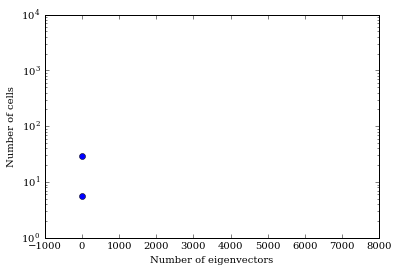

In [152]:
Ncells = calculate_Ncells(model,denomfunc=hi)
eigvecnum = np.arange(1,len(model.eigval)+1)
plt.semilogy(eigvecnum,Ncells,'o')
plt.ylabel('Number of cells')
plt.xlabel('Number of eigenvectors')

In [ ]:
direcs = ['red_clump_13_TEFF_up6011.0_lo4134.5',
          'red_clump_13_TEFF_up4900.0_lo4700.0',
          'red_clump_13_TEFF_up4900.0_lo4800.0',
          'red_clump_13_TEFF_up4800.0_lo4700.0',
          #'red_giant_13_LOGG_up2.0_lo1.7',
          'red_giant_13_LOGG_up3.0_lo2.0',
          'red_giant_13_LOGG_up4.0_lo3.0']
compare_sample(direcs,titles,models,labels,colours,slopescale=0.01,savename='DR13_comparison.png')

In [ ]:
direcs = ['red_clump_12_TEFF_up4900.0_lo4800.0']
titles = [r'$T_{\mathrm{eff}}\,\,4800\,\,K\,\,to\,\,4900\,\,K$']
models = ['eig500_minSNR50_corrNone_madFalse.pkl',
          'eig500_minSNR50_corrNone_madTrue.pkl',
          'eig500_minSNR50_corr30px_madFalse.pkl']
          #'eig500_minSNR50_corr30px_madTrue.pkl']
labels =  ['covariance','median absolute\ndeviation (M.A.D.)','covariance corrected']
colours = plt.get_cmap('plasma')(np.linspace(0,0.8,len(models)))
compare_sample(direcs,titles,models,labels,colours,slopescale=0.1,savename='mammoth_eigvec.pdf',figsize=(10,8))

In [ ]:
direcs = ['clusters_12_CLUSTER_matchN6819',
          #'clusters_13_CLUSTER_matchN6819',
          'clusters_12_CLUSTER_matchN2158',
          #'clusters_13_CLUSTER_matchN2158',
          'clusters_12_CLUSTER_matchM67']
          #'clusters_13_CLUSTER_matchM67']
titles = ['N6819',
          #'N6819-DR13',
          'N2158',
          #'N2158-DR13',
          'M67']
          #'M67-DR13']
models = ['corrNone_madFalse.pkl',
          'corrNone_madTrue.pkl',
          'corr30px_madFalse.pkl']
          #'corr30px_madTrue.pkl']
labels = ['covariance','median absolute\ndeviation (M.A.D.)','covariance corrected']#,'M.A.D. corrected']
colours = plt.get_cmap('plasma')(np.linspace(0,0.80,len(models)))
compare_sample(direcs,titles,models,labels,colours,slopescale=0.1,savename='DR12_oc_comparison.pdf')

In [ ]:
direcs = ['clusters_12_CLUSTER_matchN6819']
titles = ['N6819']
models = ['corrNone_madFalse.pkl',
          'corrNone_madTrue.pkl']
labels = ['covariance','median absolute\ndeviation (M.A.D.)']
compare_sample(direcs,titles,models,labels,colours,slopescale=0.1,savename='n6819_comparison.pdf',figsize=(10,8))

In [ ]:
from empca_residuals import *

In [ ]:
rg = empca_residuals('apogee','red_giant',maskFilter,ask=True)

In [ ]:
rc = empca_residuals('apogee','red_clump',maskFilter,ask=True)

In [ ]:
def hist2d(x,y,bins=100,clabel=False):
    H,xedges,yedges = np.histogram2d(x,y,bins=bins)
    # Reorient appropriately
    H = np.rot90(H)
    H = np.flipud(H)
    Hmasked = np.ma.masked_where(H==0,H)
    plt.pcolormesh(xedges,yedges,Hmasked,
                   cmap = plt.get_cmap('plasma'),
                   vmin=0,vmax=110)
    if clabel:
        plt.colorbar(label=clabel)

In [ ]:


import matplotlib
font = {'family': 'serif',
        'weight': 'normal',
        'size'  :  14
}
matplotlib.rc('font',**font)

In [ ]:
len(rg.data),len(rc.data)

In [ ]:
plt.figure(figsize=(15,8))
plt.subplot(121)
hist2d(rg.teff,rg.logg,bins=120)
plt.ylim(4,0)
plt.xlim(6000,3500)
plt.xticks(np.arange(4000,6000,500)[::-1])
plt.ylabel(r'$logg$',fontsize=18)
plt.xlabel(r'$T_{\mathrm{eff}}\,\,[K]$',fontsize=18)
plt.title('red giant stars')
plt.subplot(122)
hist2d(rc.teff,rc.logg,clabel='number of stars',bins=80)
plt.ylim(4,0)
plt.xlim(6000,3500)
plt.xticks(np.arange(4000,6000,500)[::-1])
plt.yticks([])
plt.xlabel(r'$T_{\mathrm{eff}}\,\,[K]$',fontsize=18)
plt.title('red clump stars')
plt.subplots_adjust(wspace=0)
plt.savefig('HRdiagram.pdf')

In [ ]:
rc.show_sample_coverage()
plt.savefig('rc_coverage.pdf')

In [ ]:
rc12= empca_residuals('apogee','red_clump',maskFilter,ask=True)

In [ ]:
rc13 = empca_residuals('apogee','red_clump',maskFilter,ask=True)

In [ ]:
import matplotlib
font = {'family': 'serif',
        'weight': 'normal',
        'size'  :  14
}
matplotlib.rc('font',**font)

In [ ]:
plt.figure(figsize=(15,5))
plt.subplot(121)
rc12.imshow(rc12.spectra_errs,vmin=0.005,vmax=0.02,cmap='plasma')
plt.title('DR12')
plt.subplot(122)
rc13.imshow(rc13.spectra_errs,vmin=0.005,vmax=0.02,cmap='plasma',ylabel='')
plt.title('DR13')
plt.subplots_adjust(wspace=0.02)
plt.savefig('DR_err_comparison.png')

In [ ]:
plt.figure(figsize=(15,5))
plt.subplot(121)
rc12.imshow(rc12.spectra,vmin=0.7,vmax=1.1,cmap='plasma')
plt.title('DR12')
plt.subplot(122)
rc13.imshow(rc13.spectra,vmin=0.7,vmax=1.1,cmap='plasma',ylabel='')
plt.title('DR13')
plt.subplots_adjust(wspace=0.02)
plt.savefig('DR_spec_comparison.png')

In [ ]:
rc12.findResiduals(gen=False)
rc13.findResiduals(gen=False)

In [ ]:
bound = 0.03
plt.figure(figsize=(15,5))
plt.subplot(121)
rc12.imshow(rc12.residuals,vmin=-bound,vmax=bound,cmap='plasma')
plt.title('DR12')
plt.subplot(122)
rc13.imshow(rc13.residuals,vmin=-bound,vmax=bound,cmap='plasma',ylabel='')
plt.title('DR13')
plt.subplots_adjust(wspace=0.02)
plt.savefig('DR_resid_comparison.png')